# Query Optimization

Used Traindata set to create inverted index and also use to tset queries

### Exploring Dataset

In [4]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [5]:
print(len(newsgroups_train['data']))

11314


In [6]:
print(newsgroups_train['data'][0])


From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [7]:
len((newsgroups_train['data'][0]).split(' '))

114

### Preprocessing

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [9]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [10]:
test_item =   newsgroups_train['data'][1].split(' ')
for w in test_item:
    if w in stop_words:
        test_item.remove(w)
        
# lemmatizer.lemmatize(newsgroups_train['data'][1])

In [11]:
print(' '.join(test_item))

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number brave souls upgraded SI clock oscillator have
shared experiences this poll. Please send brief message detailing
your experiences procedure. Top speed attained, CPU rated speed,
add cards adapters, heat sinks, hour usage per day, floppy disk
functionality 800 1.4 floppies especially requested.

I be summarizing the next two days, please add the network
knowledge base you done the clock upgrade haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



In [12]:
# Preprocess all training data
import re
from tqdm import tqdm
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and special characters (but preserve spaces)
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    words = text.split()
    # Remove stopwords and very short words (less than 2 characters)
    words = [word for word in words if word not in stop_words and len(word) > 2]
    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply preprocessing to all training data
preprocessed_data = []
print("Preprocessing training data...")
for doc in tqdm(newsgroups_train['data']):
    preprocessed_data.append(preprocess_text(doc))
    
print(f"Preprocessing complete. Sample of first preprocessed document:")
print(preprocessed_data[0][:200] + "..." if len(preprocessed_data[0]) > 200 else preprocessed_data[0])
print(f"Original document count: {len(newsgroups_train['data'])}, Preprocessed document count: {len(preprocessed_data)}")

Preprocessing training data...


100%|██████████| 11314/11314 [00:15<00:00, 725.48it/s]

Preprocessing complete. Sample of first preprocessed document:
thing subject car nntp posting host rac wam umd edu organization university maryland college park line wondering anyone could enlighten car saw day door sport car looked late early called bricklin doo...
Original document count: 11314, Preprocessed document count: 11314


An exmple of data before and after preprocessing

In [13]:
print('Before Vs After Preprocessing:\n----------------Before Preprocessing----------------\n')
print(newsgroups_train['data'][0])
print('---------After Preprocessing---------')
print(preprocessed_data[0])
print('------------------------------------')

Before Vs After Preprocessing:
----------------Before Preprocessing----------------

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





---------After Preprocessing---------
thing subject car nntp posting host rac wam umd edu organization university maryland college park line wondering anyone could enlighten car saw day door sp

### Bulding Inverted Index

In [14]:
from collections import defaultdict
import time

print("Building inverted index...")
inverted_index = defaultdict(list)

# Build the inverted index: map each word to the documents it appears in
for doc_id, doc in enumerate(tqdm(preprocessed_data)):
    # Get unique words in the document
    unique_words = set(doc.split())
    
    # Add document ID to the posting list of each word
    for word in unique_words:
        inverted_index[word].append(doc_id)

print(f"Inverted index built with {len(inverted_index)} unique terms")


Building inverted index...


100%|██████████| 11314/11314 [00:00<00:00, 25680.08it/s]

Inverted index built with 77229 unique terms


## Two Methods of Searching

In [15]:
# Function to search using the first approach: process terms with shorter posting lists first
def search_shorter_posting_lists(query_terms, inverted_index):
    if not query_terms:
        return []
    # Sort terms by length of posting lists (ascending)
    sorted_terms = sorted(query_terms, key=lambda term: len(inverted_index[term]))
    # Start with the posting list of the first term
    result = set(inverted_index[sorted_terms[0]])
    # Intersect with remaining terms
    for term in sorted_terms[1:]:
        result = result.intersection(set(inverted_index[term]))
        if not result:  # Early termination if intersection is empty
            break
    return list(result)


# Function to search using the second approach: process terms with fewer documents in the last position
def search_fewer_last_position(query_terms, inverted_index):
    if not query_terms:
        return []
    # Sort terms by the number of documents in the last position
    def count_last_position(term):
        posting_list = inverted_index[term]
        if not posting_list:
            return 0
        last_doc_id = posting_list[-1]
        
        # Pre-compute last document IDs for all query terms to avoid repeated lookups
        last_doc_ids = {t: inverted_index[t][-1] if inverted_index[t] else None for t in query_terms}
        
        # Count terms with matching last document ID
        count = sum(1 for t_id in last_doc_ids.values() if t_id == last_doc_id)
        return count
    
    # Sort once and reuse the result
    sorted_terms = sorted(query_terms, key=count_last_position)
    # Start with the posting list of the first term
    result = set(inverted_index[sorted_terms[0]])
    
    # Intersect with remaining terms
    for term in sorted_terms[1:]:
        result = result.intersection(set(inverted_index[term]))
        if not result:  # Early termination if intersection is empty
            break
    
    return list(result)

# Test the search functions with a sample query
sample_query = ["science", "computer", "wondering"]
print("\nTesting search functions with query:", sample_query)

# Filter query terms that exist in the inverted index before calling search methods
filtered_query = [term for term in sample_query if term in inverted_index]

start_time = time.time()
results1 = search_shorter_posting_lists(filtered_query, inverted_index)
time1 = time.time() - start_time
print(f"Method 1 (Shorter posting lists first): Found {len(results1)} documents in {time1:.6f} seconds")

start_time = time.time()
results2 = search_fewer_last_position(filtered_query, inverted_index)
time2 = time.time() - start_time
print(f"Method 2 (Fewer in last position): Found {len(results2)} documents in {time2:.6f} seconds")

# Compare the results
print("\nResults comparison:")
print(f"Methods return same results: {sorted(results1) == sorted(results2)}")
print(f"Speed difference: Method 1 is {time2/time1:.2f}x {'faster' if time1 < time2 else 'slower'} than Method 2")

# Display a few matching document IDs if any found
if results1:
    print("\nSample matching documents (first 3):")
    for i, doc_id in enumerate(results1[:3]):
        print(f"Document {doc_id}: {preprocessed_data[doc_id][:100]}...")



Testing search functions with query: ['science', 'computer', 'wondering']
Method 1 (Shorter posting lists first): Found 21 documents in 0.000192 seconds
Method 2 (Fewer in last position): Found 21 documents in 0.000216 seconds

Results comparison:
Methods return same results: True
Speed difference: Method 1 is 1.12x faster than Method 2

Sample matching documents (first 3):
Document 5376: david mckissock subject nasa wrap news software vax vms vnews nntp posting host lerc nasa gov organi...
Document 2442: steve lee subject stop maynard bashing roger maynard organization computer science dept univ western...
Document 2955: gordon bank subject update help lyme reply gordon bank organization univ pittsburgh computer science...


In [16]:
print('science' in preprocessed_data[results1[0]])

True


In [17]:
preprocessed_data

['thing subject car nntp posting host rac wam umd edu organization university maryland college park line wondering anyone could enlighten car saw day door sport car looked late early called bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car made history whatever info funky looking car please mail thanks brought neighborhood lerxst',
 'guy kuo subject clock poll final call summary final call clock report keywords acceleration clock upgrade article shelley qvfoinncs organization university washington line nntp posting host carson washington edu fair number brave soul upgraded clock oscillator shared experience poll please send brief message detailing experience procedure top speed attained cpu rated speed add card adapter heat sink hour usage per day floppy disk functionality floppy especially requested summarizing next two day please add network knowledge base done clock upgrade answered poll thanks guy kuo',

In [18]:
preprocessed_data[3555].split(' ')

['alexander',
 'samuel',
 'mcdiarmid',
 'subject',
 'centris',
 'video',
 'problem',
 'also',
 'organization',
 'sophomore',
 'mechanical',
 'engineering',
 'carnegie',
 'mellon',
 'pittsburgh',
 'line',
 'distribution',
 'comp',
 'nntp',
 'posting',
 'host',
 'andrew',
 'cmu',
 'edu',
 'reply',
 'pushpinder',
 'singh',
 'subject',
 'centris',
 'video',
 'problem',
 'also',
 'date',
 'sat',
 'apr',
 'gmt',
 'computer',
 'set',
 'color',
 'certain',
 'operation',
 'done',
 'particularly',
 'vertical',
 'scrolling',
 'window',
 'horizontal',
 'white',
 'line',
 'appear',
 'monitor',
 'generally',
 'always',
 'spare',
 'open',
 'window',
 'line',
 'accummulate',
 'operation',
 'continued',
 'window',
 'moved',
 'involved',
 'area',
 'screen',
 'moved',
 'away',
 'line',
 'disappear',
 'area',
 'screen',
 'problem',
 'observed',
 'monitor',
 'configured',
 'color',
 'inch',
 'apple',
 'monitor',
 'color',
 'used',
 'suspect',
 'bad',
 'video',
 'ram',
 'chip',
 'cannot',
 'certain',
 'prob

100%|██████████| 10000/10000 [00:00<00:00, 43059.09it/s]


Testing Method 1: Shorter posting lists first


100%|██████████| 10000/10000 [00:01<00:00, 5372.80it/s]


Testing Method 2: Fewer in last position


100%|██████████| 10000/10000 [00:01<00:00, 5034.92it/s]


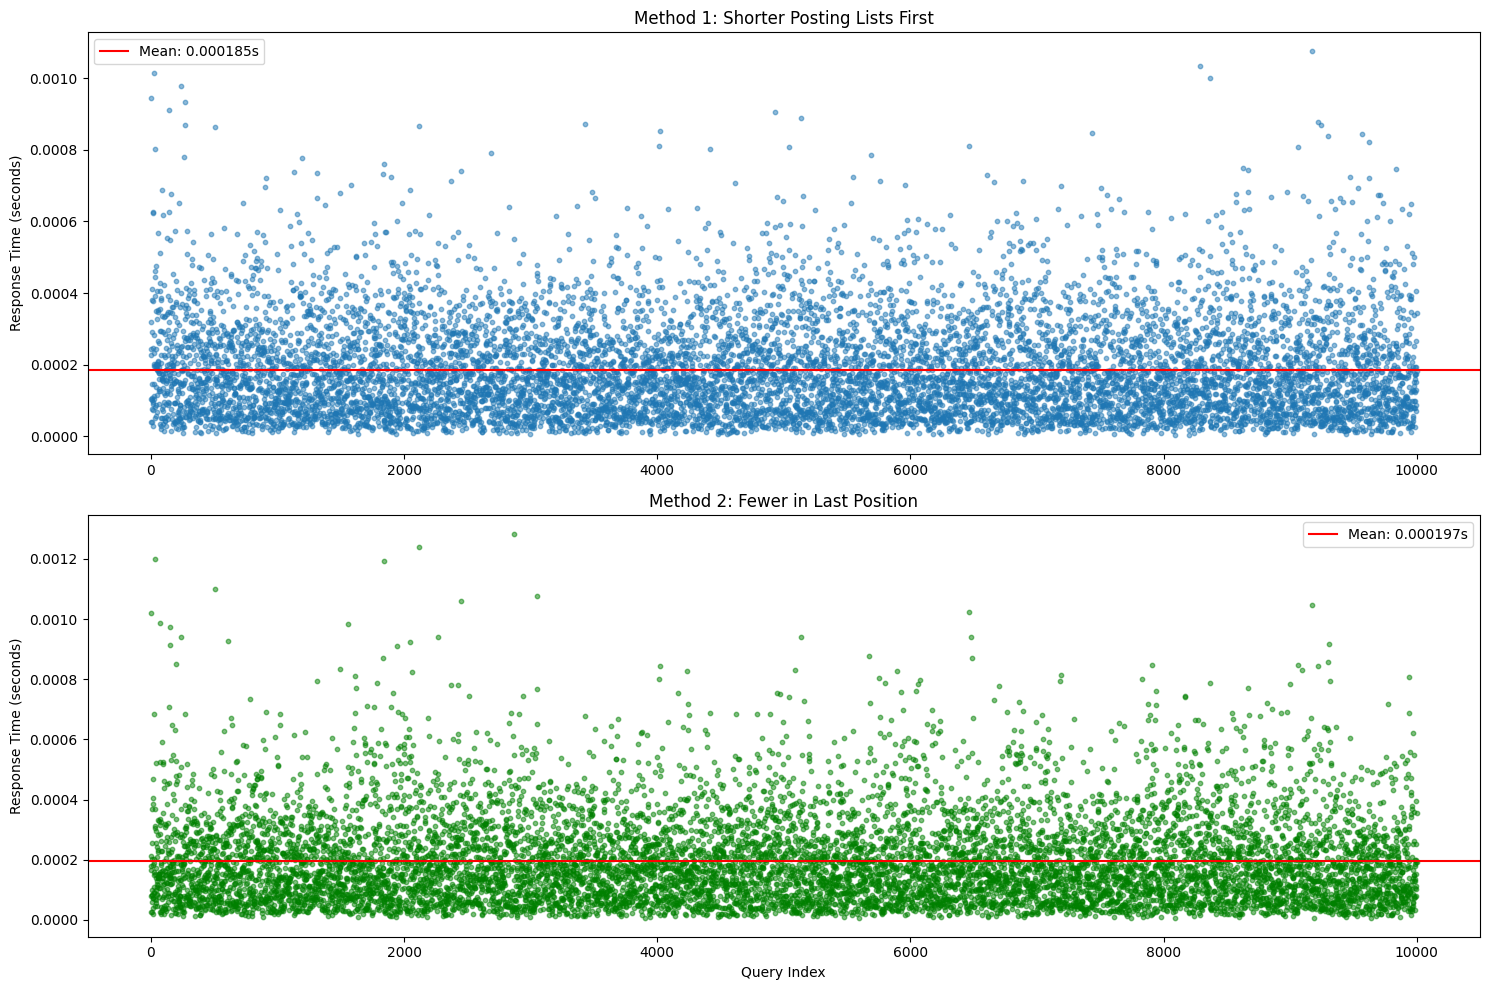


Comparison Statistics:
Method 1 - Average response time: 0.000185 seconds
Method 2 - Average response time: 0.000197 seconds
Speed ratio: Method 1 is 1.07x faster than Method 2


/var/folders/tz/8b88qlx557g0hfgcm5j26kr00000gn/T/ipykernel_1623/2946111192.py:100: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([method1_times, method2_times], labels=['Method 1', 'Method 2'])


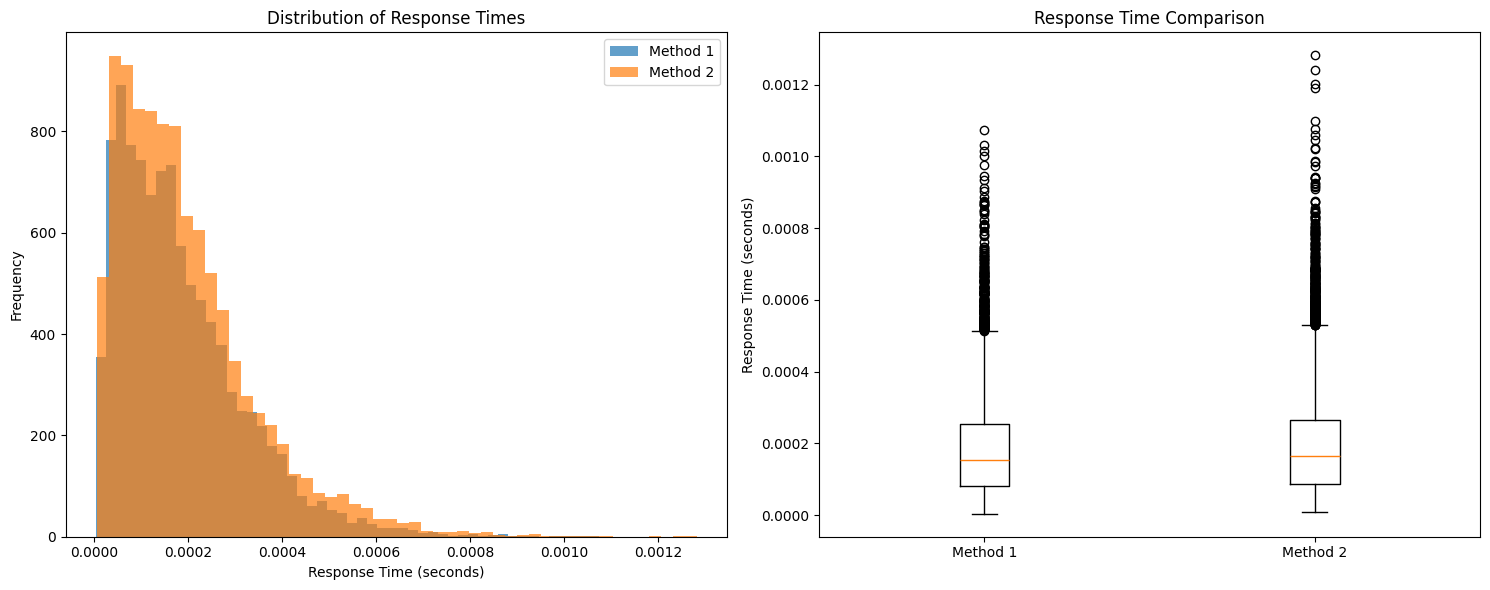

In [ ]:
# Generate 10000 random queries with more than 3 terms
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Get all unique terms from the inverted index
all_terms = list(inverted_index.keys())

# Generate random queries
num_queries = 10000
random_queries = []
for _ in tqdm(range(num_queries)):
    # Select random number of terms (3 to 7)
    num_terms = random.randint(3, 7)
    # Select random terms from preprocessed documents
    query_terms = []
    # Randomly select a document
    random_doc_id = random.randint(0, len(preprocessed_data) - 1)
    doc_words = preprocessed_data[random_doc_id].split(' ')
    # If document has enough words, select random terms from it
    if len(doc_words) >= num_terms:
        query_terms = random.sample(doc_words, num_terms)
    else:
        # If document doesn't have enough words, use terms from inverted index
        query_terms = random.sample(all_terms, num_terms)
    
    # Ensure all terms are in the inverted index
    query_terms = [term for term in query_terms if term in inverted_index]
    
    # Only add if we have at least 2 terms
    if len(query_terms) >= 2:
        random_queries.append(query_terms)

# Test both search methods on all random queries
method1_times = []
method2_times = []
method1_results_count = []
method2_results_count = []

print("Testing Method 1: Shorter posting lists first")
for query in tqdm(random_queries):
    start_time = time.time()
    results = search_shorter_posting_lists(query, inverted_index)
    elapsed_time = time.time() - start_time
    method1_times.append(elapsed_time)
    method1_results_count.append(len(results))

print("Testing Method 2: Fewer in last position")
for query in tqdm(random_queries):
    start_time = time.time()
    results = search_fewer_last_position(query, inverted_index)
    elapsed_time = time.time() - start_time
    method2_times.append(elapsed_time)
    method2_results_count.append(len(results))
    
    
    
# Create scatter plots
plt.figure(figsize=(15, 10))

# Method 1 scatter plot
plt.subplot(2, 1, 1)
plt.scatter(range(len(method1_times)), method1_times, alpha=0.5, s=10)
plt.axhline(y=np.mean(method1_times), color='r', linestyle='-', label=f'Mean: {np.mean(method1_times):.6f}s')
plt.title('Method 1: Shorter Posting Lists First')
plt.ylabel('Response Time (seconds)')
plt.legend()

# Method 2 scatter plot
plt.subplot(2, 1, 2)
plt.scatter(range(len(method2_times)), method2_times, alpha=0.5, s=10, color='green')
plt.axhline(y=np.mean(method2_times), color='r', linestyle='-', label=f'Mean: {np.mean(method2_times):.6f}s')
plt.title('Method 2: Fewer in Last Position')
plt.xlabel('Query Index')
plt.ylabel('Response Time (seconds)')
plt.legend()

plt.tight_layout()
plt.savefig('query_response_times_2.png')
plt.show()

# Comparison statistics
print("\nComparison Statistics:")
print(f"Method 1 - Average response time: {np.mean(method1_times):.6f} seconds")
print(f"Method 2 - Average response time: {np.mean(method2_times):.6f} seconds")
print(f"Speed ratio: Method 1 is {np.mean(method2_times)/np.mean(method1_times):.2f}x {'faster' if np.mean(method1_times) < np.mean(method2_times) else 'slower'} than Method 2")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(method1_times, bins=50, alpha=0.7, label='Method 1')
plt.hist(method2_times, bins=50, alpha=0.7, label='Method 2')
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Response Times')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot([method1_times, method2_times], labels=['Method 1', 'Method 2'])
plt.ylabel('Response Time (seconds)')
plt.title('Response Time Comparison')

plt.tight_layout()
plt.savefig('response_time_distribution_2.png')
plt.show()


In [21]:
# Calculate the difference between methods
time_differences = []
for i in range(len(random_queries)):
    # Calculate ratio of method2 to method1 (how many times faster/slower)
    # Ensure both times are non-zero to avoid division issues
    if method1_times[i] > 0 and method2_times[i] > 0:
        ratio = method2_times[i] / method1_times[i]
        time_differences.append((i, ratio, random_queries[i]))

# Find queries where methods differ most
# Method 1 is better when ratio is high (method2 takes longer)
method1_better = sorted(time_differences, key=lambda x: x[1], reverse=True)[:10]
# Method 2 is better when ratio is low (method1 takes longer)
method2_better = sorted(time_differences, key=lambda x: x[1])[:10]

# Store the best items
best_items = {
    "method1_better": [(idx, query, ratio) for idx, ratio, query in method1_better],
    "method2_better": [(idx, query, ratio) for idx, ratio, query in method2_better]
}


In [26]:
print("\nTop 2 queries where Method 1 performs better:")
for idx, query, ratio in best_items["method1_better"]:
    results = search_shorter_posting_lists(query, inverted_index)
    print(f"Query {idx}: {query} - Method 2 is {ratio:.2f}x slower")
    print(f"  Found {len(results)} documents")
    # Print inverted index info for each word
    for word in query:
        if word in inverted_index:
            print(f"  Word '{word}' appears in {(inverted_index[word])}")
        else:
            print(f"  Word '{word}' not found in index")
    # if results:
    #     print(f"  Sample documents (first 2):")
    #     for doc_id in results[:2]:
    #         print(f"    Document {doc_id}: {preprocessed_data[doc_id][:50]}...")

print("\n\n\n\nn\n\n\n----------------------------------------\nTop 2 queries where Method 2 performs better:")
for idx, query, ratio in best_items["method2_better"]:
    results = search_fewer_last_position(query, inverted_index)
    print(f"Query {idx}: {query} - Method 1 is {1/ratio:.2f}x slower")
    print(f"  Found {len(results)} documents")
    # Print inverted index info for each word
    for word in query:
        if word in inverted_index:
            print(f"  Word '{word}' appears in {(inverted_index[word])}")
        else:
            print(f"  Word '{word}' not found in index")
    # if results:
    #     print(f"  Sample documents (first 2):")
    #     for doc_id in results[:2]:
    #         print(f"    Document {doc_id}: {preprocessed_data[doc_id][:50]}...")


Top 2 queries where Method 1 performs better:
Query 1005: ['apt', 'finnegan', 'never'] - Method 2 is 7.39x slower
  Found 1 documents
  Word 'apt' appears in [17, 83, 1454, 1474, 2934, 3714, 4441, 4638, 5191, 5464, 5920, 6499, 6794, 7343, 7662, 7703, 8087, 8325, 8383, 9262, 9597, 9789, 9930, 10110, 10426]
  Word 'finnegan' appears in [216, 1474, 2522]
  Word 'never' appears in [11, 14, 17, 22, 39, 53, 54, 70, 74, 86, 93, 121, 124, 131, 135, 147, 157, 160, 163, 168, 182, 195, 203, 208, 216, 222, 223, 230, 245, 254, 262, 279, 298, 300, 303, 352, 369, 416, 419, 443, 453, 461, 507, 514, 523, 527, 554, 561, 563, 572, 591, 614, 627, 628, 630, 644, 649, 650, 656, 691, 692, 700, 707, 723, 725, 728, 729, 730, 732, 734, 742, 746, 750, 753, 757, 761, 765, 769, 771, 784, 792, 799, 801, 805, 818, 820, 821, 830, 855, 858, 875, 876, 877, 883, 893, 913, 919, 923, 936, 939, 943, 947, 961, 982, 983, 989, 990, 999, 1004, 1006, 1011, 1017, 1033, 1035, 1036, 1062, 1089, 1094, 1097, 1106, 1109, 1114, 1115,

In [43]:
best_items["method1_better"][0]

(7728, ['always', 'day', 'counting', 'somewhere', 'gaj'], 24.971553610503282)